### OLS 회귀분석

In [6394]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

from scipy import stats
from scipy.stats import shapiro

import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

### 환경설정
np.random.seed(4)


### 함수 정의
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

def trim_date(df, start, end):
    ### df date 형식 맞춰주기
    df['date'] = df['date'].astype(str)
    if len(df['date'][0]) == 8:
        df['date'] = df['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])


    return df[(df['date']>=start) & (df['date']<=end)]

In [6395]:
price_df = pd.read_csv('./data/price/bitcoin_price_coin_market_cap.csv').set_index('date')
price_df

,open,high,low,close,volume,marketCap
date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,8.036550e+06,4.297536e+09
2015-01-02,314.079010,315.838989,313.565002,315.032013,7.860650e+06,4.309551e+09
2015-01-03,314.846008,315.149994,281.082001,281.082001,3.305440e+07,3.846270e+09
2015-01-04,281.145996,287.230011,257.612000,264.195007,5.562910e+07,3.616321e+09
2015-01-05,265.084015,278.341003,265.084015,274.473999,4.396280e+07,3.758098e+09
...,...,...,...,...,...,...
2025-03-08,86742.652990,86847.267594,85247.484188,86154.593210,1.820612e+10,1.708771e+12
2025-03-09,86154.305891,86471.130163,80052.486979,80601.041311,3.089935e+10,1.598205e+12
2025-03-10,80597.149784,83955.926252,77420.592186,78532.001808,5.406110e+10,1.558444e+12


### 데이터 세팅

In [6396]:
# ### 학습용 데이터 읽기
# test_df = pd.read_csv("./data/test/test_df.csv")
# test_df.set_index('date', inplace=True)
### 학습용 데이터 읽기
test_df = pd.read_csv("./data/test/test_df.csv")
test_df.set_index('date', inplace=True)
test_df

magazine_pro = pd.read_csv("./data/test/magazine_preprocessed_index.csv").set_index('date')

test_df = test_df.merge(magazine_pro, left_index=True, right_index=True, how='left')

test_df['close'] = price_df['close']
test_df['open'] = price_df['open']
test_df['high'] = price_df['high']
test_df['low'] = price_df['low']
test_df['volume'] = price_df['volume']
test_df['returns'] = test_df['close'].pct_change()
test_df['returns_during_2'] = test_df['close'].pct_change(2)
test_df['returns_during_3'] = test_df['close'].pct_change(3)
test_df['returns_during_4'] = test_df['close'].pct_change(4)


### Realized Volatility 추가
test_df['rv'] = test_df['returns'].rolling(5).std()
test_df['rv'] = test_df['rv'].fillna(test_df['rv'].mean())

### 이벤트용 데이터 읽기
# event_df = pd.read_csv("./data/event/bitcoin_event_details_sentiment.csv")
event_df = pd.read_csv("./data/event/bitcoin_event_detail_no_explain.csv")
event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])
# event_df = event_df[event_df['predict']==1]

# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_33_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_3_day_transactions_over_136_threshold_100_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_25_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_25_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_33_receive.csv")
target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_receive.csv")
target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_receive_df.columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']

target_event_receive_df = trim_date(target_event_receive_df, (test_df.index)[0], (test_df.index)[-1])


### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
# pos, neg, neu, all
event_sentiment = 'all'
if event_sentiment == 'all':
    pass
elif event_sentiment == 'pos':
    event_df = event_df[event_df['classification']==1]
elif event_sentiment == 'neg':
    event_df = event_df[event_df['classification']==0]
elif event_sentiment == 'neu':
    event_df = event_df[event_df['classification']==2]
event_df['classification'] = 1
event_df = event_df['classification']
event_df = event_df[~event_df.index.duplicated(keep='first')]

test_df['event_flag'] = event_df
test_df['event_flag'] = test_df['event_flag'].fillna(0)
event_flag_copy = test_df['event_flag'].values

test_df['big_returns_flag'] = test_df['abs_returns'].apply(lambda x: 1 if x >= 0.05 else 0)
big_returns_flag_copy = test_df['big_returns_flag'].values

### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']
test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### VPIN 관련 변수 추가
vpin = pd.read_csv('./data/vpin/vpin.csv')
vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
vpin = vpin.set_index('date')

test_df['vpin'] = vpin['vpin']
test_df['vpin_ma_10'] = vpin['ma_10']

### 회귀분석 돌릴때 Cheating 방지용으로 transaction 관련 target값 삭제
transaction_count = test_df['transaction_count'].copy()
transaction_amount = test_df['transaction_amount'].copy()
transaction_amount_usd = test_df['transaction_amount_usd'].copy()

### 수익률 관련 변수
returns_copy = test_df['returns'].copy()

##### 전처리 관련
### 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
test_df = test_df.replace([np.inf, -np.inf], np.nan)

### NaN값 처리 방법
test_df = test_df.fillna(test_df.mean())

### 스케일링
scaler = StandardScaler()
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns, index=test_df.index)

### 스케일링 유의 변수
test_df['returns'] = returns_copy
test_df['event_flag'] = event_flag_copy
test_df['big_returns_flag'] = big_returns_flag_copy

In [6397]:
target_event_receive_df

,date,transaction_count,transaction_amount,transaction_flag
0,2017-01-01,5,10000.0,1
1,2017-01-02,0,0.0,0
2,2017-01-03,0,0.0,0
3,2017-01-04,5,7500.0,1
4,2017-01-05,0,0.0,0
...,...,...,...,...
2825,2024-09-26,0,0.0,0
2826,2024-09-27,0,0.0,0
2827,2024-09-28,2,6400.0,1
2828,2024-09-29,0,0.0,0


In [6398]:
pd.set_option('display.max_columns', None)
test_df

,transaction_count,transaction_amount,transaction_flag,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time,10Yr+ HODL Wave,1Yr+ HODL Wave,5Yr+ HODL Wave,Addresses with > 0 BTC,Addresses with > 0.01 BTC,Addresses with > 0.1 BTC,Addresses with > 1 BTC,Addresses with > 10 BTC,Addresses with > 100 BTC,"Addresses with > 1,000 BTC","Addresses with > 10,000 BTC",Balanced Price,Active Addresses 7DMA,Hash Rate 7DMA,Miner Difficulty,Circulating Supply,CDD (90dma),CVDD,Delta Top,Long-Term Holder Realized Price,Miner Revenue - Block Rewards,Miner Revenue - Fees,Miner Fees %,Miner Revenue - Total,New Addresses,Addresses in Loss,Addresses in Profit,Realized Price,MVOCD,Short-Term Holder Realized Price,Supply Adjusted CDD (90dma),Terminal Price,Top Cap,VDD Multiple,Whale Shadows,returns_during_2,returns_during_3,returns_during_4,rv,event_flag,big_returns_flag,transaction_amount_usd,target,target_delta,target_returns,vpin,vpin_ma_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,-0.296743,-0.183598,0.894569,NaN,-1.125305,0.000000,-1.202099,-1.126478,-1.126335,-1.125605,-0.752190,-1.669788e-16,0.000000,0.000000,0.000000,-6.677695e-17,0.000000,0.000000,0.000000,1.906936e-16,0.000000,0.000000,0.000000,-1.616865e-18,0.000000,6.472890e-18,-6.366045e-18,-1.438860e-18,4.067258e-18,2.330567e-18,0.000000,0.000000,0.000000,-1.219491e-16,-1.393576e-16,0.000000,-1.384638e-16,-1.385767e-16,0.000000,-1.318389e-16,6.953688e-16,0.000000,3.645692e-16,0.000000,0.000000,1.936683e-16,0.000000,0.000000,1.652036e-16,0.000000,-5.403927e-16,2.357973e-16,-5.153963e-16,0.000000,-4.867979e-16,-5.204247e-16,-1.099428e-15,-1.524501e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.391100,-0.004522,-1.283663,-1.827698,-1.924960,-1.896433,-2.052649,-1.119430,2.277760,-1.345102,0.596044,-1.329585,-1.582273,-1.011193,-1.010653,-2.076837,-0.621870,-1.235382,-1.360063,-1.203051,1.212060,-0.149535,-0.373813,1.080115,-2.249975,-1.468576,1.468576,-1.329661,-0.880017,-1.153263,-0.341108,-1.277422,-1.173342,0.442407,-0.092031,0.000000,1.325116e-17,0.000000,0.000000,0.0,0,-0.213040,-0.213040,-4.886114e-20,0.000000,1.169821,-0.006735
2017-01-02,-0.313983,-0.194081,-1.117856,0.023464,-1.124117,0.653487,-1.198160,-1.124704,-1.124930,-1.123629,-0.640992,-1.669788e-16,0.000000,0.000000,0.000000,-6.677695e-17,0.000000,0.000000,0.000000,1.906936e-16,0.000000,0.000000,0.000000,-1.616865e-18,0.000000,6.472890e-18,-6.366045e-18,-1.438860e-18,4.067258e-18,2.330567e-18,0.000000,0.000000,0.000000,-1.219491e-16,-1.393576e-16,0.000000,-1.384638e-16,-1.385767e-16,0.000000,-1.318389e-16,-8.700713e-01,-1.572275,-8.474623e-01,-1.315835,-1.010971,-1.097035e+00,1.558431,-0.527752,-1.004574e+00,-1.187699,5.654632e-02,-1.371472e+00,-2.384392e-01,-0.469625,-1.648762e+00,-2.587986e-01,-7.066792e-01,-1.715789e-01,-0.862324

### Target의 Returns예측

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.590
Date:                Sun, 23 Mar 2025   Prob (F-statistic):             0.0323
Time:                        10:18:01   Log-Likelihood:                 4740.7
No. Observations:                2465   AIC:                            -9477.
Df Residuals:                    2463   BIC:                            -9466.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

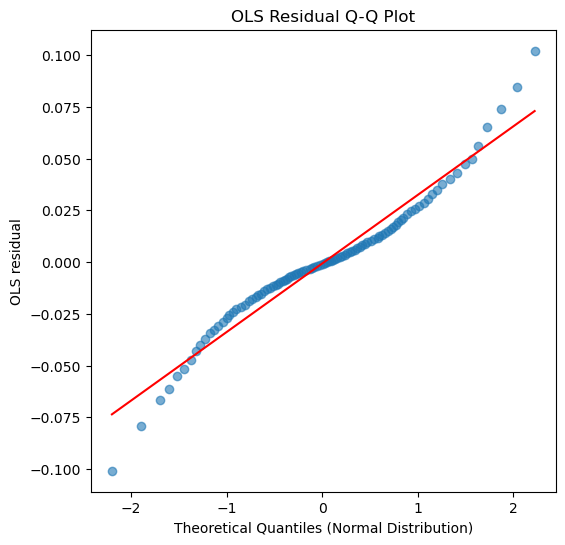

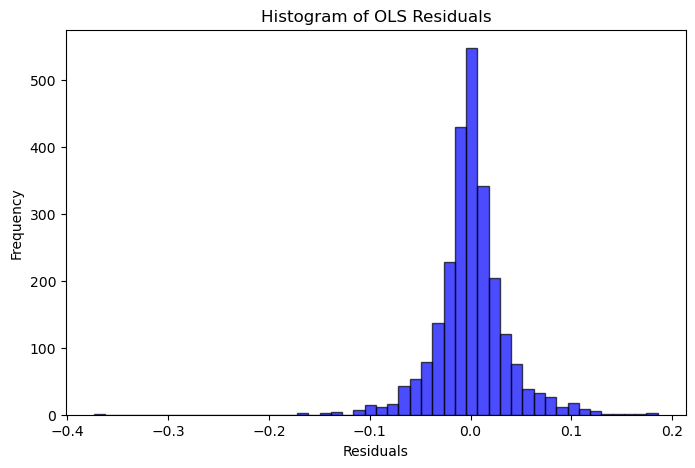

In [6399]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-5).fillna(test_df['returns'].mean())
X = test_df[['target']].fillna(test_df.mean())


# # train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin'].shift(1)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())


### OLS Residual의 Q-Q Plot (정규성 확인)

normal_dist = lambda l : np.random.standard_normal(l)

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

residual_q = lr.resid.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(lr.resid)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, residual_q, alpha=0.6)

x, y = nd_q, residual_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('OLS residual')
plt.title('OLS Residual Q-Q Plot')
plt.show()

### OLS Residual의 히스토그램 (정규성 확인)
plt.figure(figsize=(8, 5))
plt.hist(lr.resid, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of OLS Residuals")
plt.show()


### During 2 day returns 예측

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:       returns_during_3   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.94
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           0.000193
Time:                        10:18:01   Log-Likelihood:                -3300.9
No. Observations:                2465   AIC:                             6606.
Df Residuals:                    2463   BIC:                             6617.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

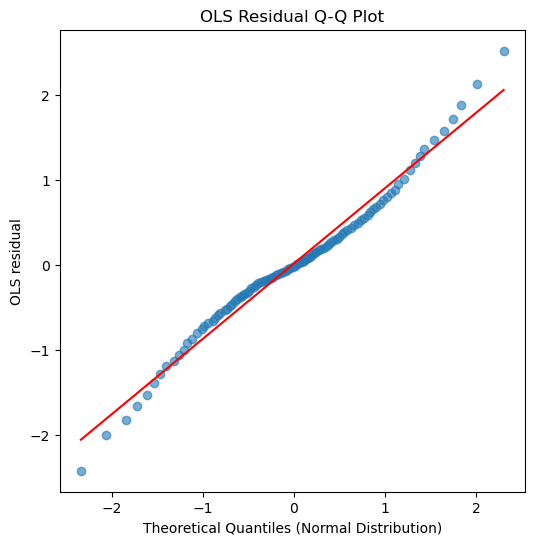

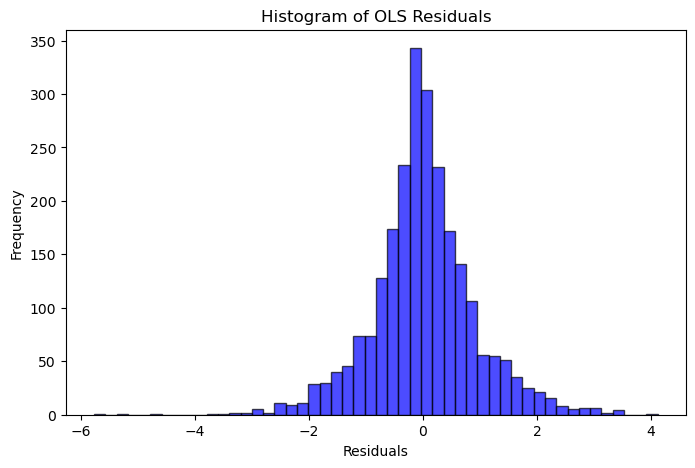

In [6400]:
# Independent, Dependent 분리
y = test_df['returns_during_3'].shift(-5).fillna(test_df['returns_during_3'].mean())
X = test_df[['target']].fillna(test_df.mean())


# # train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin'].shift(1)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())


### OLS Residual의 Q-Q Plot (정규성 확인)

normal_dist = lambda l : np.random.standard_normal(l)

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

residual_q = lr.resid.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(lr.resid)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, residual_q, alpha=0.6)

x, y = nd_q, residual_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('OLS residual')
plt.title('OLS Residual Q-Q Plot')
plt.show()

### OLS Residual의 히스토그램 (정규성 확인)
plt.figure(figsize=(8, 5))
plt.hist(lr.resid, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of OLS Residuals")
plt.show()


### Event Flag를 더미변수로 추가하면 기울기가 늘어나는지

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.08670
Date:                Sun, 23 Mar 2025   Prob (F-statistic):              0.768
Time:                        10:18:02   Log-Likelihood:                 4732.0
No. Observations:                2465   AIC:                            -9460.
Df Residuals:                    2463   BIC:                            -9448.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cons

C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\1296380572.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['event_flag'] = X['event_flag'].shift(-2).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\1296380572.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_event'] = X['target'] * X['event_flag']


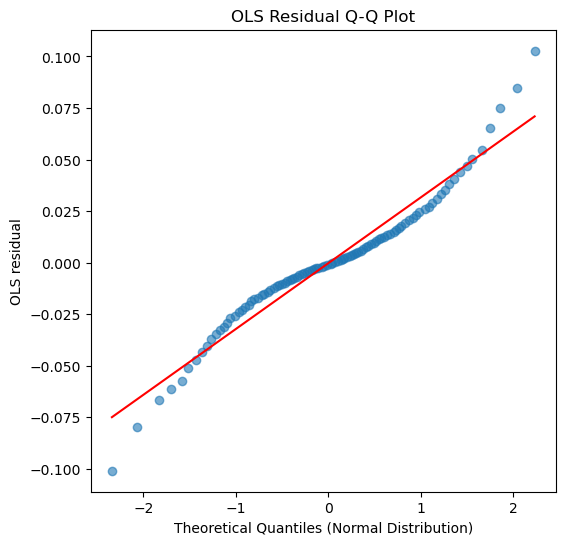

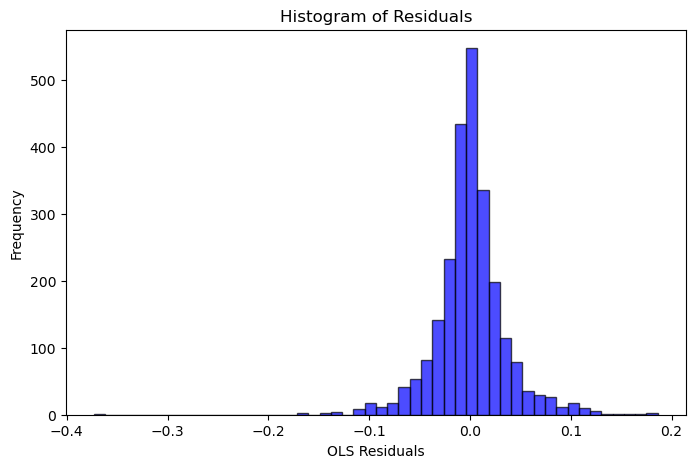

Shapiro-Wilk Test Statistic: 0.9237094894887196, p-value: 1.1894165519447075e-33
Jarque-Bera Test Statistic: 6376.67626280053, p-value: 0.0
Residual Variance: 0.0012592321299962578
Residual Standard Deviation: 0.03548566090685444


In [6401]:
# 파생변수 추가
test_df['event_target'] = test_df['target'] * test_df['event_flag'].shift(0).fillna(0)

# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target', 'volume', 'event_flag']]
X['event_flag'] = X['event_flag'].shift(-2).fillna(0)
X['target_event'] = X['target'] * X['event_flag']
X = X[['target_event']]

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())



stat, p = shapiro(lr.resid)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")




bp_test = het_breuschpagan(lr.resid, lr.model.exog)
print(f"Breusch-Pagan Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}")



### OLS Residual의 Q-Q Plot (정규성 확인)
normal_dist = lambda l : np.random.standard_normal(l)

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

residual_q = lr.resid.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(lr.resid)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, residual_q, alpha=0.6)

x, y = nd_q, residual_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('OLS residual')
plt.title('OLS Residual Q-Q Plot')

plt.show()

### OLS Residual의 히스토그램 (정규성 확인)
plt.figure(figsize=(8, 5))
plt.hist(lr.resid, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("OLS Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


### 샤피로 테스트 (정규성 검정)
stat, p = shapiro(lr.resid)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")

### jarque bera (왜도, 첨도 검정)
jb_stat, jb_pvalue, _, _ = jarque_bera(lr.resid)
print(f"Jarque-Bera Test Statistic: {jb_stat}, p-value: {jb_pvalue}")

### Variance, Standard Deviation
print(f"Residual Variance: {np.var(lr.resid)}")
print(f"Residual Standard Deviation: {np.std(lr.resid)}")

### Big Returns Flag 추가 설명력 확인

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.642
Date:                Sun, 23 Mar 2025   Prob (F-statistic):              0.200
Time:                        10:18:02   Log-Likelihood:                 4742.5
No. Observations:                2465   AIC:                            -9481.
Df Residuals:                    2463   BIC:                            -9469.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\1811912051.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['big_returns_flag'] = X['big_returns_flag'].shift(-5).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\1811912051.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_big_returns'] = X['vpin'] * X['big_returns_flag']


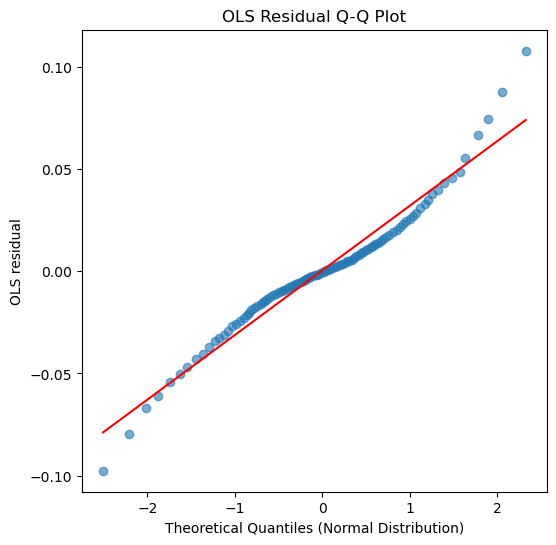

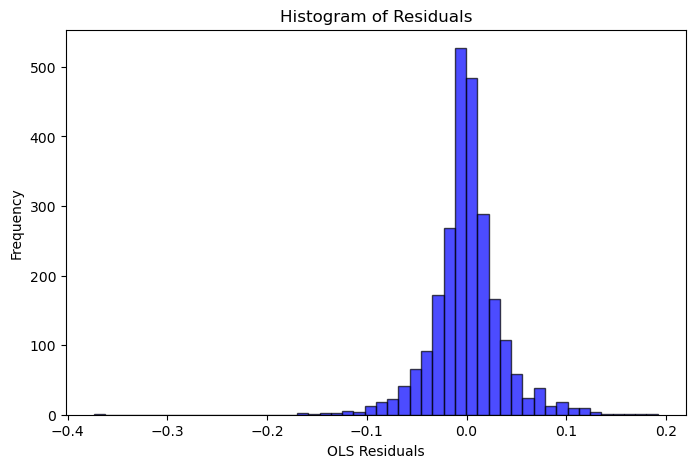

Shapiro-Wilk Test Statistic: 0.9231448412652583, p-value: 9.458378554551521e-34
Jarque-Bera Test Statistic: 6501.818713358243, p-value: 0.0
Residual Variance: 0.0012485584209242081
Residual Standard Deviation: 0.035334946171236885


In [6402]:
# 파생변수 추가
test_df['event_target'] = test_df['target'] * test_df['event_flag'].shift(0).fillna(0)

# Independent, Dependent 분리
y = test_df['returns'].shift(-5).fillna(test_df['returns'].mean())
X = test_df[['target', 'volume', 'vpin', 'big_returns_flag']]
X['big_returns_flag'] = X['big_returns_flag'].shift(-5).fillna(0)
X['target_big_returns'] = X['vpin'] * X['big_returns_flag']
X = X[['target_big_returns']]

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())



stat, p = shapiro(lr.resid)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")




bp_test = het_breuschpagan(lr.resid, lr.model.exog)
print(f"Breusch-Pagan Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}")



### OLS Residual의 Q-Q Plot (정규성 확인)
normal_dist = lambda l : np.random.standard_normal(l)

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

residual_q = lr.resid.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(lr.resid)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, residual_q, alpha=0.6)

x, y = nd_q, residual_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('OLS residual')
plt.title('OLS Residual Q-Q Plot')

plt.show()

### OLS Residual의 히스토그램 (정규성 확인)
plt.figure(figsize=(8, 5))
plt.hist(lr.resid, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("OLS Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


### 샤피로 테스트 (정규성 검정)
stat, p = shapiro(lr.resid)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")

### jarque bera (왜도, 첨도 검정)
jb_stat, jb_pvalue, _, _ = jarque_bera(lr.resid)
print(f"Jarque-Bera Test Statistic: {jb_stat}, p-value: {jb_pvalue}")

### Variance, Standard Deviation
print(f"Residual Variance: {np.var(lr.resid)}")
print(f"Residual Standard Deviation: {np.std(lr.resid)}")

### 과거 변동성이 Target을 잘 설명하는지

In [6403]:
test_df['volatility'] = test_df['returns']**2
test_df['std_5'] = test_df['returns'].rolling(5).std()
test_df['volume_5'] = test_df['volume'].rolling(5).std()

# Independent, Dependent 분리
y = test_df['target']
X = test_df[['volume_5', 'std_5']].fillna(test_df.mean())

# ## train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     7.442
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           0.000599
Time:                        10:18:02   Log-Likelihood:                -1574.8
No. Observations:                2465   AIC:                             3156.
Df Residuals:                    2462   BIC:                             3173.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

### Target의 변화값이 Returns를 유의미하게 설명하는지

In [6404]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-1).fillna(test_df['returns'].mean())
X = test_df[['vpin']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

start = '2017-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin'].shift(1).fillna(test_df['vpin'].mean())
# X_test['volume'] = test_df['volume'].shift(1).fillna(test_df['volume'].mean())
# # X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.315
Date:                Sun, 23 Mar 2025   Prob (F-statistic):              0.252
Time:                        10:18:03   Log-Likelihood:                 5256.5
No. Observations:                2830   AIC:                        -1.051e+04
Df Residuals:                    2828   BIC:                        -1.050e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

### Target의 변화율이 Returns를 유의미하게 설명하는지

In [6405]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin'].shift(1).fillna(test_df['vpin'].mean())

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
# lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.147
Date:                Sun, 23 Mar 2025   Prob (F-statistic):             0.0132
Time:                        10:18:03   Log-Likelihood:                 4735.1
No. Observations:                2465   AIC:                            -9466.
Df Residuals:                    2463   BIC:                            -9454.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------


### Target 변화량, 변화율, 값으로 Returns 예측

In [6406]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'vpin', 'returns']]
# X['target'] = X['target'].shift(1).fillna(X['target'].mean())
# X['vpin'] = X['vpin']*X['returns']
X['vpin'] = X['vpin'].shift(1).fillna(X['vpin'].mean())


start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.414
Date:                Sun, 23 Mar 2025   Prob (F-statistic):            0.00421
Time:                        10:18:03   Log-Likelihood:                 4737.0
No. Observations:                2465   AIC:                            -9466.
Df Residuals:                    2461   BIC:                            -9443.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------


C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\709608801.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['vpin'] = X['vpin'].shift(1).fillna(X['vpin'].mean())


In [6407]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-4).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'event_flag']]
X['event_flag'] = X['event_flag'].shift(-4).fillna(0)
X['target_event'] = X['target_returns'] * X['event_flag']
X = X['target_event'].to_frame()


start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.452
Date:                Sun, 23 Mar 2025   Prob (F-statistic):              0.228
Time:                        10:18:03   Log-Likelihood:                 4733.4
No. Observations:                2465   AIC:                            -9463.
Df Residuals:                    2463   BIC:                            -9451.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cons

C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3513468418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['event_flag'] = X['event_flag'].shift(-4).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3513468418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_event'] = X['target_returns'] * X['event_flag']


In [6408]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'target', 'event_flag', 'vpin', 'volume', 'returns', 'rv']]
X['event_flag'] = X['event_flag'].shift(-3).fillna(0)
X['target_event'] = X['target'] * X['event_flag']
X['target_event'] = X['target_event'].shift(0).fillna(0)
X['vpin'] = X['vpin'].shift(-2).fillna(X['vpin'].mean())
X['returns'] = X['returns'].shift(-2).fillna(X['returns'].mean())
X['volume'] = X['volume'].shift(-2).fillna(X['volume'].mean())
X['rv'] = X['rv'].shift(-2).fillna(X['rv'].mean())
X = X[['target_returns', 'target_event', 'vpin']]

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.454
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           5.75e-05
Time:                        10:18:03   Log-Likelihood:                 4738.6
No. Observations:                2465   AIC:                            -9469.
Df Residuals:                    2461   BIC:                            -9446.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0012      0.001      1.

C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3403225607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['event_flag'] = X['event_flag'].shift(-3).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3403225607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_event'] = X['target'] * X['event_flag']
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3403225607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [6409]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-5).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'target', 'event_flag', 'vpin', 'volume', 'returns', 'rv', 'n-transactions']]
X['target_returns'] = X['target_returns'].shift(-2).fillna(method='ffill')
X['event_flag'] = X['event_flag'].shift(-5).fillna(0)
X['target_event'] = X['target'] * X['event_flag']
X['target_event'] = X['target_event'].shift(-2).fillna(0)
X['vpin'] = X['vpin'].shift(0).fillna(X['vpin'].mean())
X['returns'] = X['returns'].shift(-4).fillna(X['returns'].mean())
X['volume'] = X['volume'].shift(-2).fillna(X['volume'].mean())
X['rv'] = X['rv'].shift(-4).fillna(X['rv'].mean())
X['target'] = X['target'].shift(0).fillna(X['target'].mean())
X['n-transactions'] = X['n-transactions'].shift(0).fillna(X['n-transactions'].mean())
X = X[['target', 'target_returns', 'vpin', 'volume', 'returns', 'rv', 'n-transactions']]
# , 'target_event', 'vpin', 'volume', 'returns', 'rv',
start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.510
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           0.000940
Time:                        10:18:03   Log-Likelihood:                 4751.7
No. Observations:                2465   AIC:                            -9487.
Df Residuals:                    2457   BIC:                            -9441.
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------


C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\559726871.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X['target_returns'] = X['target_returns'].shift(-2).fillna(method='ffill')
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\559726871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_returns'] = X['target_returns'].shift(-2).fillna(method='ffill')
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\559726871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [6410]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'target', 'big_returns_flag', 'vpin', 'volume', 'returns', 'rv', 'n-transactions']]
X['target_returns'] = X['target_returns'].shift(0).fillna(method='ffill')
X['big_returns_flag'] = X['big_returns_flag'].shift(-3).fillna(0)
X['target'] = X['target'].shift(0).fillna(X['target'].mean())
X['target_big_returns'] = X['target'] * X['big_returns_flag']
X['target_big_returns'] = X['target_big_returns'].shift(0).fillna(0)
X['vpin'] = X['vpin'].shift(-2).fillna(X['vpin'].mean())
X['returns'] = X['returns'].shift(-2).fillna(X['returns'].mean())
X['volume'] = X['volume'].shift(-2).fillna(X['volume'].mean())
X['rv'] = X['rv'].shift(-2).fillna(X['rv'].mean())
# X['target'] = X['target'].shift(2).fillna(X['target'].mean())
X['n-transactions'] = X['n-transactions'].shift(-1).fillna(X['n-transactions'].mean())
X = X[['target_returns', 'target_big_returns', 'vpin', 'volume', 'returns', 'rv', 'n-transactions']]
# , 'target_event', 'vpin', 'volume', 'returns', 'rv'
start = '2024-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3829531229.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X['target_returns'] = X['target_returns'].shift(0).fillna(method='ffill')
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3829531229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_returns'] = X['target_returns'].shift(0).fillna(method='ffill')
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3829531229.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.507
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           9.14e-05
Time:                        10:18:03   Log-Likelihood:                 593.33
No. Observations:                 274   AIC:                            -1171.
Df Residuals:                     266   BIC:                            -1142.
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3829531229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['returns'] = X['returns'].shift(-2).fillna(X['returns'].mean())
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3829531229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['volume'] = X['volume'].shift(-2).fillna(X['volume'].mean())
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\3829531229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

### Event Flag 추가 Target 3종세트 Returns 예측

In [6411]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'target', 'event_flag']]
X['event_flag'] = X['event_flag'].shift(-3).fillna(0)
X['target_event'] = X['target'] * X['event_flag']
X = X[['target_event', 'target_returns']]

start = '2024-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\1076028199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['event_flag'] = X['event_flag'].shift(-3).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_29060\1076028199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_event'] = X['target'] * X['event_flag']


=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.529
Date:                Sun, 23 Mar 2025   Prob (F-statistic):             0.0116
Time:                        10:18:03   Log-Likelihood:                 588.90
No. Observations:                 274   AIC:                            -1172.
Df Residuals:                     271   BIC:                            -1161.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
